# Spectral plotter

<div>
    When using this program, you need to make sure your data is inserted correctly. <br/> Make sure you have a <b>data</b> folder in the same directory as this notebook.
</div>
<img src="files/directoryView.png"/>
<div>
    Inside the data folder you need to create a new folder for the star you want to analyse.
</div>
<img src="files/dataView.png"/>
<div>
    In the folder for each star you would want to have the following data structure:
    <ul>
        <li>Directly inside the folder all the .fit files containing the spectra (preferrably an odd amount)</li>
        <li>A <b>dark</b> folder containing all the dark frames, which would be substracted from the averaged spectral image</li>
        <li>A <b>lamp</b> folder containing an image of the lamp used for calibration.</li>
    </ul>
    NOTE: The <b>results</b> folder should be created automatically.
</div>
<img src="files/folderView.png"/>

When executing the program only write in the name of the folder(in this case <b>'28Tau'</b>) and do not worry for the names of the .fit files inside the directory, they will be found automatically.

In [1]:
#Input star(directory) name
star_name = '28Tau'

In [2]:
import glob
#Input file directories
input_files = glob.glob('data/' + star_name + '/*.fit')
#Directories of the dark images
dark_files = glob.glob('data/' + star_name + '/dark/*.fit')
output_location = 'data/' + star_name + '/results/' + star_name + '.fit'

In [4]:
# Prerequisites
from astropy.io import fits 
from astropy.table import Table 
from pathlib import Path
import numpy as np 
import matplotlib.pyplot as plt 
import math
%matplotlib inline 

# Build lists of darks and their corresponding data
dark = list()
data_dark = list()
for i in range(len(dark_files)):
    dark.append( fits.open(dark_files[i]) )
    data_dark.append( dark[i][0].data )

#  Get header information of any dark
# (darks must be _identical_ in shape)
header = dark[0][0].header

# Get the master dark array from median of all darks
mdark_arr = np.median(data_dark, axis=0)

# Initialise lists of exposures and their corresponding data
inputs = list()
data_inputs = list()

# For each individual exposure, ...
for i in range(len(input_files)):
    # ... append the exposure to the list, ...
    inputs.append( fits.open(input_files[i]) )
    # ... and substract the master dark element-wise!
    data_inputs.append( inputs[i][0].data - mdark_arr )

# Get the master image from median of all exposures
output = np.median(data_inputs, axis=0)

# Save the master image 2D array as a fits file, ...
hdu=fits.PrimaryHDU(output)
hdulist=fits.HDUList([hdu])
# ... and write it to the desired location
Path("data/" + star_name + '/results').mkdir(parents=True, exist_ok=True)
hdulist.writeto(output_location, overwrite=True)

In [5]:
#Prerequisites for editing
input_file = output_location
# Range of y in which all of the signal is contained
rangelow = 560
rangeup = 610
# Upper bound from which pixels will be removed
cosm_filt = 110000

#lamp wavelengths - requires manual search for the wavelengths of the emission lines
line_lambda = [
    6598.95,
    6532.88,
    6506.30
]

lamp_file = glob.glob('data/' + star_name + '/lamp/*.fit')[0]
otpt_file = 'data/' + star_name + '/results/' + star_name + '.png'
max_otpt = 300
spectrum_y = 580

Lamp calibration - fit parameters:
a = -0.1117
b = 6671.8863
Peaks: [652, 1247, 1480]


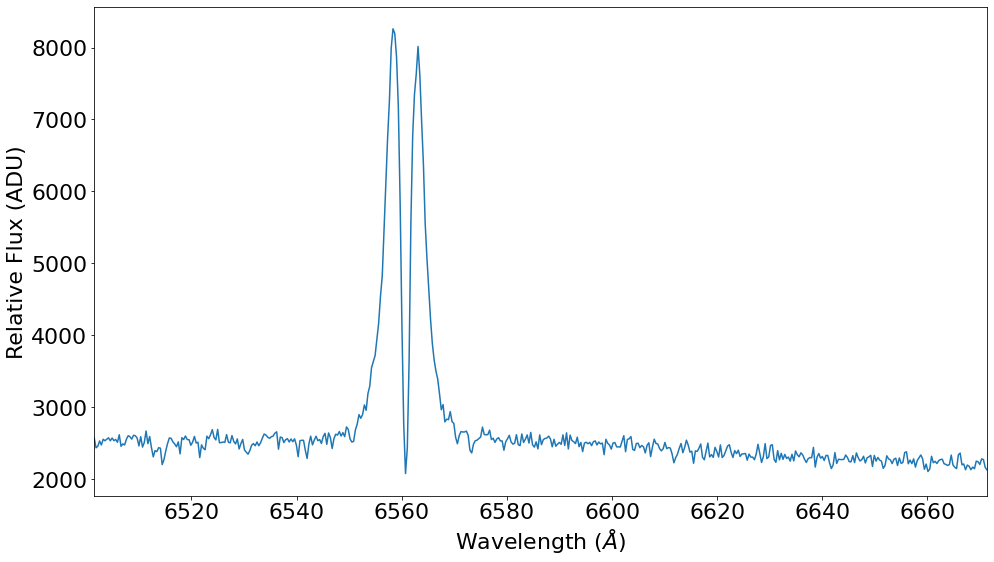

In [6]:
# Loading input file
datahdu = fits.open(input_file) 
data, hdr = datahdu[0].data, datahdu[0].header

# Initialising axes
y = range(hdr['NAXIS1'])

# Summing all 'good' pixels in a column
# (ones that are not cosmics or burnt out)
xdata = np.sum(data[rangelow:rangeup,:], axis=0)
            
# Loading lamp file
lamp = fits.open(lamp_file)
lamp_data, lamp_hdr = lamp[0].data, lamp[0].header
lamp_1d = list()

# Get a horizontal line from the lamp file
for i in range(lamp_hdr['NAXIS1']):
    lamp_1d.append(lamp_data[spectrum_y,i])

# Get lamp peaks
lamp_len = len(lamp_1d)
peaks = list()
for i in range(lamp_len):
    if i!=0 and i!=lamp_len-1:
        # Local maximum check
        cond1 = float(lamp_1d[i])-float(lamp_1d[i-1]) < 0
        cond2 = float(lamp_1d[i+1]) - float(lamp_1d[i]) < 0
        # Check if local maximum is not noise (edit if there are more lines to fit)
        cond3 = lamp_1d[i] > 3000
        if (cond1 != cond2) and cond3:
            peaks.append(i)
            
# Calibrate lamp by fitting a line from maxima and wavelengths
poly = np.polyfit(peaks,line_lambda,1)
a, b = poly[0], poly[1]
print("Lamp calibration - fit parameters:")
print("a = {0:.4f}".format(a))
print("b = {0:.4f}".format(b))
print(f"Peaks: {peaks}")

img_len = len(xdata)
avg_list = list()
# Smooth calibration step
st = 3
# Get the size of the array with the given step
size = math.floor(img_len/st)
rng = np.arange(size*st,step = st)
for i in rng:
    if i+st-1 < img_len:
        # Get the median of [st] number of consecutive pixels
        avg_list.append(np.median(xdata[i:i+st-1]))
        
# Gets the range of wavelengths and cuts the first and last 5 data points
x = np.linspace(a*(st*size-5)+b,a*5+b,num = size-10)
# Reverse the dataset
data = avg_list[5:size-5]
data.reverse()

# Plot graph
plt.figure(figsize=(16,9))
plt.rcParams.update({'font.size':22})
plt.plot(x,data)
plt.xlabel(r"Wavelength ($\AA$)")
plt.ylabel("Relative Flux (ADU)")
plt.xlim(a*(st*size-5)+b,a*5+b)
plt.savefig(otpt_file)